# Fixed Wing Electric sUAS Sizing 
By Matthew Capece

Loosely based on lecture notes of Dr. Mark Maughmer

### Setup

##### Imports

In [717]:
import numpy as np
import matplotlib.pyplot as plt

##### Constants

In [718]:
# Physical Constants
gravity = 9.80665               # m/s^2

# Standard Sea Level Atmosphere
density = 1.225                 # kg/m^3
temp_C = 15                     # C
temp_K = 288.2                  # K
pressure = 101325               # Pa
speed_of_sound = 340.3          # m/s
dynamic_viscosity = 1.789e-5    # kg/m/s
kinematic_viscosity = 1.460e-5  # m^2/s
gas_constant = 287.1            # J/kg/K
temp_lapse_rate = 0.0065        # K/m
molar_mass = 0.0289652          # kg/mol
ratio_of_specific_heats = 1.4   # unitless

### Mission Requirements

In [719]:
# Performance Requirements
range = 29              # km
endurance = 30          # min
m_payload = 2.7         # kg, payload mass (not required to fly)
v_stall = 10            # m/s, stall speed
v_cruise = 18           # m/s, cruise speed
v_touchdown = 13        # m/s, landing touchdown speed 
dist_to_roll = 20       # m
dist_land_roll = 25     # m
radius_turn = 30        # m
angle_climb_min = 20    # deg
angle_descent_min = 20  # deg

# Size Requirements
m_to_max = 25           # kg, takeoff (total) mass
span_max = 2.5          # m

# Calculations
dynamic_pressure_cruise = 1/2 * density * v_cruise**2
dynamic_pressure_stall = 1/2 * density * v_stall**2
dynamic_pressure_touchdown = 1/2 * density * v_touchdown**2
bank_angle_max_rad = np.arctan(v_cruise**2/ (gravity * radius_turn))  # Max bank angle required for a sustained level turn with specified truning radius
bank_angle_max_deg = bank_angle_max_rad * 180 / np.pi
bank_load_factor_max = 1 / np.cos(bank_angle_max_rad)                 # Lift load factor at max bank angle 
touchdown_speed_ratio = v_touchdown / v_stall                         # Ratio of touchdown speed over stall speed (j)

### Initial Estimates

In [720]:
# Educated guesses based on experience and knowledge of similar aircraft
chord_inital = .3  # m
span_initial = 2   # m
m_to_initial = 7   # kg
e0_initial = .75    # Oswald Efficiency
e_initial = .9     # Span Efficiency
Cdo_initial = .02  # Parasite drag coefficient
lift_over_weight_landing = .15  # Estimated ratio of average L/W during landing ground roll
gear_rolling_friction = .35     # rolling friction coefficient for landing gear on pavement (for 3 wheels)

# Initial Airfoil Selection
# Airfoil: psu94097-il
Cl_max = 1.2
Cl_max_flaps = 1.6
Cl_0 = .5

# Calculations
w_to_initial = gravity * m_to_initial 
wing_area_initial = chord_inital * span_initial  # Estimates wing area as a rectangular wing
AR_initial = span_initial**2 / wing_area_initial
k_initial = 1 / (e0_initial * np.pi * AR_initial)

Re_cruise_inital = (density * v_cruise * chord_inital) / dynamic_viscosity
Re_stall_initial = (density * v_stall * chord_inital) / dynamic_viscosity


### Constraint Diagrams

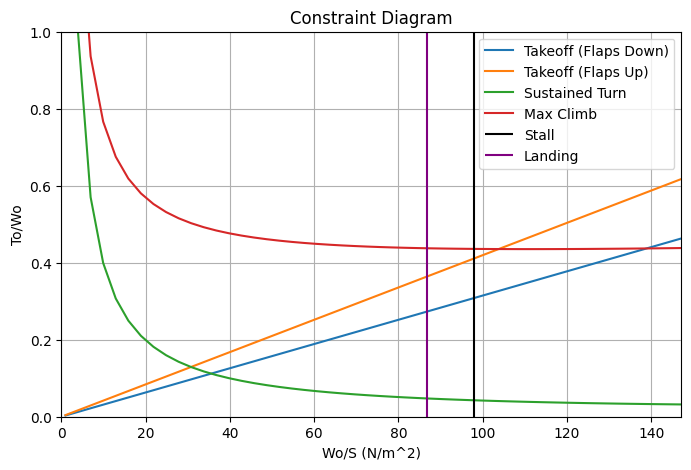

In [721]:
# Data Range
wing_loading_max = 150  # g/dm^2, Wing loading using mass (NOT WEIGHT)
wing_loading_weight_max = wing_loading_max / 10 * gravity  # N/m^2, Wing Loading in terms of weight (NOT MASS) 
wing_loading_array = np.linspace(1, wing_loading_weight_max)  #N/m^2, Plotted Wing Loading Range

# Takeoff Calculation
thrust_to_weight_to_flaps_array = wing_loading_array * [1.21 / (gravity * density * Cl_max_flaps * dist_to_roll)]  # Takeoff Curve WITH FLAPS
thrust_to_weight_to_array = wing_loading_array * [1.21 / (gravity * density * Cl_max * dist_to_roll)]  # Takeoff Curve WITHOUT FLAPS

# Landing Calculation (ROUGH)
Cd_land_inital = Cdo_initial + Cl_0**2 / (np.pi * e_initial * AR_initial)       # Estimated Drag Coefficient during landing
D_land_initial = (dynamic_pressure_touchdown/4) * wing_area_initial * Cd_land_inital  # N, Estimated Average Drag during landing ground roll
wing_loading_landing = dist_land_roll * (gravity * density * Cl_max_flaps * (D_land_initial / w_to_initial + gear_rolling_friction *(1 - lift_over_weight_landing))) / touchdown_speed_ratio**2 #ROUGH ESTIMATE

# Climb
climb_gradient_min = np.tan(angle_climb_min * np.pi / 180)  # Ratio of vertical speed over horizontal speed (angle in deg)
thrust_to_weight_climb_array = wing_loading_array * (k_initial / dynamic_pressure_cruise) + (dynamic_pressure_cruise * Cdo_initial) / wing_loading_array  +  climb_gradient_min

# Stall Speed Wingloading
wing_loading_stall_inital = dynamic_pressure_stall * Cl_max_flaps   # Wingloading at stall WITH FLAPS

# Sustained Turn Calculation
thrust_to_weight_bank_array = ((bank_load_factor_max * k_initial * wing_loading_array) / dynamic_pressure_cruise)**2 + dynamic_pressure_cruise * Cdo_initial / wing_loading_array

# Plot Constraints
fig, ax = plt.subplots(figsize=(8,5))
xlim = wing_loading_array[-1]
ylim = 1
ax.plot(wing_loading_array, thrust_to_weight_to_flaps_array, label='Takeoff (Flaps Down)')
ax.plot(wing_loading_array, thrust_to_weight_to_array, label='Takeoff (Flaps Up)')
ax.plot(wing_loading_array, thrust_to_weight_bank_array, label='Sustained Turn')
ax.plot(wing_loading_array, thrust_to_weight_climb_array, label='Max Climb')
ax.vlines(wing_loading_stall_inital, 0, ylim, label = 'Stall', colors='black')
ax.vlines(wing_loading_landing, 0, ylim, label = 'Landing', colors='purple')
ax.set_xlim([0,xlim])
ax.set_ylim([0,ylim])
ax.set_title('Constraint Diagram')
ax.set_xlabel('Wo/S (N/m^2)')
ax.set_ylabel('To/Wo')
ax.grid()
ax.legend(loc='upper right')

### Preliminary Design

##### Preliminary Wing Design

In [722]:
#Inputs
airfoil = "psu94097-il"
#CONFIRM THESE VALUES WITH XFOIL
Cl_max = 1.2
Cl_max_flaps = 1.6
Cl_0 = .5

# Dimensions assuming trapezoidal
wing_span = 2.5  # m, wing span
wing_chord_root = .40  # m, wing root chord
wing_chord_tip = .25  # m, wing tip chord

# Calculations
wing_area = (wing_chord_root + wing_chord_tip) / 2 * wing_span  # m^2, wing area
wing_aspect_ratio = wing_span**2 / wing_area  # aspect ratio
wing_taper_ratio = wing_chord_tip / wing_chord_root  # wing taper ratio
wing_mean_aero_chord = 2 * wing_chord_root / 3 * (1 + wing_taper_ratio + wing_taper_ratio**2) / (1 + wing_taper_ratio)  # m, wing mean aerodynamic chord

# Outputs
print(f"Airfoil: {airfoil:s}")
print(f"Wing Span: {wing_span:.2f} m")
print(f"Wing Root Chord: {wing_chord_root:.2f} m")
print(f"Wing Tip Chord: {wing_chord_tip:.2f} m")
print(f"Wing Area: {wing_area:.2f} m^2")
print(f"Wing Aspect Ratio: {wing_aspect_ratio:.2f} m^2")

Airfoil: psu94097-il
Wing Span: 2.50 m
Wing Root Chord: 0.40 m
Wing Tip Chord: 0.25 m
Wing Area: 0.81 m^2
Wing Aspect Ratio: 7.69 m^2


##### Preliminary Fuselage Design

In [723]:
# Inputs
length_total = wing_span * .8  # m, overall length of the aircraft, tip to tail
fuselage_radius = .15  # m, radius of fuselage if approximated as a cylinder

# Outputs
print(f"Total Length: {length_total:.2f} m")
print(f"Fuselage Radius: {fuselage_radius:.2f} m")

Total Length: 2.00 m
Fuselage Radius: 0.15 m


##### Preliminary Tail Design

In [724]:
# Airfoil: 

# Inputs
tail_volume_coeff_H = .6  # desired horizontal tail volume coefficient
tail_volume_coeff_V = .03 # desired vertical tail volume coefficient 
tail_aspect_ratio_H = wing_aspect_ratio / 2 # Needs to be less than wing so tail stalls after wing
tail_aspect_ratio_V = 1.5 # Based on span from chord to tip
length_wing_tail = .5 * length_total # m, Distance from wing aero center to tail aero center (Maybe like .5-.6 should be the l/L ratio)
tail_taper_ratio_H = wing_taper_ratio  # Assume same as wing
tail_taper_ratio_V = wing_taper_ratio  # Assume same as wing


# Calculations

# Horizontal Tail
tail_area_H = tail_volume_coeff_H * wing_mean_aero_chord * wing_area / length_wing_tail  # m^2, required horizontal tail area
tail_chord_root_H = 2 * tail_area_H / ((tail_area_H * tail_aspect_ratio_H)**.5 * (1 + tail_taper_ratio_H))  # m, horizontal tail root chord
tail_chord_tip_H = tail_chord_root_H * tail_taper_ratio_H  # m, horizontal tail tip chord
tail_span_H = (tail_area_H * tail_aspect_ratio_H)**.5  # m, horizontal tail span (From tip to tip)
tail_mean_aero_chord_H = 2 * tail_chord_root_H / 3 * (1 + tail_taper_ratio_H + tail_taper_ratio_H**2) / (1 + tail_taper_ratio_H)  # m, horizontal tail mean aerodynamic chord

# Vertical Tail
tail_area_V = tail_volume_coeff_V * wing_span * wing_area / length_wing_tail  # m^2, required vertical tail area
tail_chord_root_V = 2 * tail_area_V / ((tail_area_V * tail_aspect_ratio_V)**.5 * (1 + tail_taper_ratio_V))  # m, vertical tail root chord
tail_chord_tip_V = tail_chord_root_V * tail_taper_ratio_V  # m, vertical tail tip chord
tail_span_V = (tail_area_V * tail_aspect_ratio_V)**.5  # m, vertical tail span (From root to tip)
tail_mean_aero_chord_V = 2 * tail_chord_root_V / 3 * (1 + tail_taper_ratio_V + tail_taper_ratio_V**2) / (1 + tail_taper_ratio_V)  # m, vertical tail mean aerodynamic chord

# Outputs
print(f"Horizontal Tail Span: {tail_span_H:.2f} m")
print(f"Horizontal Tail Root Chord: {tail_chord_root_H:.2f} m")
print(f"Horizontal Tail Tip Chord: {tail_chord_tip_H:.2f} m")
print(f"Horizontal Tail Area: {tail_area_H:.2f} m^2")
print(f"Vertical Tail Span: {tail_span_V:.2f} m")
print(f"Vertical Tail Root Chord: {tail_chord_root_V:.2f} m")
print(f"Vertical Tail Tip Chord: {tail_chord_tip_V:.2f} m")
print(f"Vertical Tail Area: {tail_area_V:.2f} m^2")
print(f"Wing AC to Tail AC: {length_wing_tail:.2f} m")

Horizontal Tail Span: 0.79 m
Horizontal Tail Root Chord: 0.25 m
Horizontal Tail Tip Chord: 0.16 m
Horizontal Tail Area: 0.16 m^2
Vertical Tail Span: 0.30 m
Vertical Tail Root Chord: 0.25 m
Vertical Tail Tip Chord: 0.16 m
Vertical Tail Area: 0.06 m^2
Wing AC to Tail AC: 1.00 m


##### Preliminary Drivetrain Design

In [725]:
# Inputs

specific_energy = 150  # W*hr/kg, LiPo specific energy
prop_efficiency = .6  # Estimated prop efficiency
system_efficiency = .73 # Estimated Motor*ESC*Battery efficiency
L_D_estimate = 6  # L/D Estimate for cruise
# advance_ratio_cruise = .44 # Advance Ratio for cruise conditions for 12 x 8 APC prop
# thrust = 4 lbs per prop
# Power = .645 HP per prop

# Calculations
specific_energy_seconds = specific_energy *3600  # W*s/kg
range_m = range*1000  # m, required aircraft range
w_bat_fraction = (gravity / specific_energy_seconds) * range_m / (L_D_estimate * prop_efficiency * system_efficiency) # weight fraction of battery (w_bat/w_to) - From Electric Range Equation

# Outputs
print(f"Battery Mass Fraction: {w_bat_fraction:.2f}")

Battery Mass Fraction: 0.20


##### Takeoff Weight Estimate - Detailed

In [726]:
# Inputs
w_empty_fraction = .5  # estimated weight fraction of vehicle without battery or payload

# Calculations
w_payload = m_payload * 9.81  # N, max payload weight
w_to = w_payload / (1 - w_empty_fraction - w_bat_fraction)  # N, max takeoff weight
m_to = w_to / 9.81  # kg, max takeoff mass
w_empty = w_to * w_empty_fraction  # N, empty weight (no vehicle or payload)
m_empty = w_empty / 9.81  # kg, empty mass (no vehicle or payload)
w_bat = w_to * w_bat_fraction # N, battery weight
m_bat = w_bat / 9.81  # kg, battery mass

# Outputs
print(f"Takeoff Mass: {m_to:.2f} kg")
print(f"Empty Mass: {m_empty:.2f} kg")
print(f"Battery Mass: {m_bat:.2f} kg")
print(f"Payload Mass: {m_payload:.2f} kg")

Takeoff Mass: 9.01 kg
Empty Mass: 4.51 kg
Battery Mass: 1.81 kg
Payload Mass: 2.70 kg


### Performance Calculations

##### General Dimensions

In [727]:
print("Overall Dimensions")
print(f"Airfoil: {airfoil:s}")
print(f"Wing Span: {wing_span:.2f} m")
print(f"Wing Area: {wing_area:.2f} m^2")
print(f"Wing Aspect Ratio: {wing_aspect_ratio:.2f} m^2")
print(f"Horizontal Tail Area: {tail_area_H:.2f} m^2")
print(f"Vertical Tail Area: {tail_area_V:.2f} m^2")
print(f"Total Length: {length_total:.2f} m")
print(f"Payload Mass: {m_payload:.2f} kg")
print(f"Takeoff (Gross) Mass: {m_to:.2f} kg")

Overall Dimensions
Airfoil: psu94097-il
Wing Span: 2.50 m
Wing Area: 0.81 m^2
Wing Aspect Ratio: 7.69 m^2
Horizontal Tail Area: 0.16 m^2
Vertical Tail Area: 0.06 m^2
Total Length: 2.00 m
Payload Mass: 2.70 kg
Takeoff (Gross) Mass: 9.01 kg


##### General Estimates

In [728]:

e0 = .65    # Oswald Efficiency
e = .9     # Span Efficiency
Cdo = .02  # Parasite drag coefficient
k = 1 / (e0_initial * np.pi * AR_initial)  # Drag polar constant


print("\nEstimations:")
print(f"Cruise Speed: {v_cruise:.2f} m/s")
print(f"Oswald Efficiency: {e0:.2f}")
print(f"Cd0: {Cdo:.2f}")
print(f"CL Max: {Cl_max_flaps:.2f}")  # With flaps
print(f"LiPo Specific Energy: {specific_energy:.2f} W*hr/kg")
print(f"Prop Efficiency: {prop_efficiency:.2f}")
print(f"System Efficiency: {system_efficiency:.2f}")



Estimations:
Cruise Speed: 18.00 m/s
Oswald Efficiency: 0.65
Cd0: 0.02
CL Max: 1.60
LiPo Specific Energy: 150.00 W*hr/kg
Prop Efficiency: 0.60
System Efficiency: 0.73


##### General Cruise Calulations

In [729]:
# Calculations
Re_cruise = (density * v_cruise * wing_mean_aero_chord ) / dynamic_viscosity  # Cruise reynolds number
Re_stall = (density * v_stall * wing_mean_aero_chord) / dynamic_viscosity  # Stall reynolds number
Cl_cruise = w_to / (dynamic_pressure_cruise * wing_area)  # Cruise Lift Coefficient
wing_loading_cruise = w_to / wing_area  # N/m^2, calculated wing loading


# Outputs
print(f"Cruise Reynolds Number: {Re_cruise:.2f}")
print(f"Cruise Lift Coefficient: {Cl_cruise:.2f}")
print(f"Cruise Wing Loading: {wing_loading_cruise:.2f} N/m^2")

Cruise Reynolds Number: 407683.71
Cruise Lift Coefficient: 0.55
Cruise Wing Loading: 108.81 N/m^2


##### Drag Polar

L/D Cruise: 5.67
Cruise Drag: 15.60 N
L/D Max: 7.11
Minimum Drag: 12.43 N
Minimum Drag Velocity: 12.84 m/s
T/W Cruise: 0.18


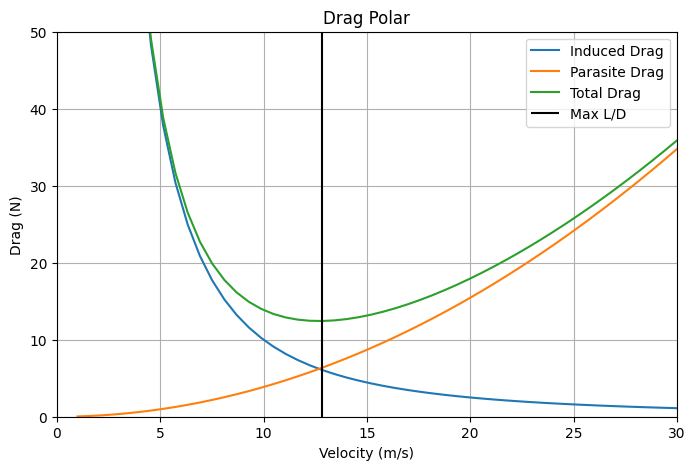

In [735]:
# Inputs
from IPython.core.displayhook import Float


wetted_area = 2 * (wing_area + tail_area_H + tail_area_V) + 2 * np.pi * fuselage_radius**2 + np.pi * fuselage_radius * length_total # estimated wetted area
v = np.linspace(1, 30)  # m/s, velocity range to plot

# Calculations
drag_induced = (w_to / wing_span)**2 / (.5 * density * v**2 * np.pi * e0)  # N, Induced Drag Plot
drag_parasite = .5 * density * v**2 * wetted_area * Cdo  # N, Parasite Drag Plot
drag_total = drag_parasite + drag_induced  # N, Total Drag Plot

drag_min = np.amin(drag_total)  # N, Minimum Drag
drag_min_idx = np.where(drag_total == drag_min)   # Array index where minimum drag occurs
v_max_L_D = float(v[drag_min_idx[0]])  # m/s, velocity of minimum drag / max L/D
L_D_Max = w_to/drag_min # maximum L/D

# Plot Drag Polar
fig, ax = plt.subplots(figsize=(8,5))
xlim = v[-1]
ylim = 50
ax.plot(v, drag_induced, label='Induced Drag')
ax.plot(v, drag_parasite, label='Parasite Drag')
ax.plot(v, drag_total, label='Total Drag')
ax.vlines(v[drag_min_idx[0]], 0, ylim, label = 'Max L/D', colors='black') # MAX L/D
ax.set_xlim([0,xlim])
ax.set_ylim([0,ylim])
ax.set_title('Drag Polar')
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Drag (N)')
ax.grid()
ax.legend(loc='upper right')

# More Calculations
drag_induced_cruise = (w_to / wing_span)**2 / (.5 * density * v_cruise**2 * np.pi * e0)  # N, Induced Drag
drag_parasite_cruise = .5 * density * v_cruise**2 * wetted_area * Cdo  # N, Parasite Drag
drag_cruise = drag_parasite_cruise + drag_induced_cruise  # N, Total Drag
L_D_cruise = w_to / drag_cruise  # Cruise Lift/Drag ratio (L = W in steady level flight)
T_W_cruise = drag_cruise / w_to  # Cruise T/W ratio (T = D in steady level flight)

# Outputs
print(f"L/D Cruise: {L_D_cruise:.2f}")
print(f"Cruise Drag: {drag_cruise:.2f} N")
print(f"L/D Max: {L_D_Max:.2f}")
print(f"Minimum Drag: {drag_min:.2f} N")
print(f"Minimum Drag Velocity: {v_max_L_D:.2f} m/s")
print(f"T/W Cruise: {T_W_cruise:.2f}")

##### Performance Calculations

In [731]:
print("\nPerformance Metrics:")

# Stall Speed
v_stall_calc = (2 * w_to / (density * wing_area * Cl_max_flaps))**.5  # m/s, calculated stall speed
print(f"Stall Speed: {v_stall_calc:.2f} m/s")

# Range
range_calc = m_bat * specific_energy_seconds * L_D_cruise * prop_efficiency * system_efficiency / w_to  # m, calculated range
print(f"Range: {range_calc:.2f} m")

# Endurance 
endurance_calc = range_calc / v_cruise / 60  # min, calculated cruise endurance
print(f"Endurance: {endurance_calc:.2f} min")


# Max Turn radius
# Max Bank Angle
# Max Load Factor
# Max Rate of Climb
# TO Distance
# Landing Distance
# Cruise Thrust/Power
# TO Thrust/Power



Performance Metrics:
Stall Speed: 10.54 m/s
Range: 27380.11 m
Endurance: 25.35 min


##### Stability Analysis